In [5]:
class Batch:
    def __init__(self, quality):
        self.quality = quality
        self.alpha = 1
        self.beta = 1

    def sample_distribution(self):
        return np.random.beta(self.alpha, self.beta)

    def get_element(self):
        good = np.random.rand() < self.quality
        self.alpha += int(good)
        self.beta += 1 - int(good)
        return good

class Factory:
    def __init__(self):
        self.batches = []
        self.systems = 0
        self.good = 0

    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]

    def get_element(self):
        samples = [batch.sample_distribution() for batch in self.batches]
        choice = np.argmax(samples)
        result = self.batches[choice].get_element()
        self.systems += 1
        self.good += result
        return result

# Reproduce example
qualities = [0.5, 0.6, 0.7]
factory = Factory()
factory.set_batches(qualities)

results = []
for _ in range(1000):
    results.append(factory.get_element())

print("Total systems:", factory.systems)
print("Good systems:", factory.good)

Total systems: 1000
Good systems: 684


Strategy: Best Perf, Good systems: 709
Strategy: Next B A L, Good systems: 607
Strategy: Ranked Select, Good systems: 3808
Strategy: Custom, Good systems: 591
Strategy: Expo Decay, Good systems: 614


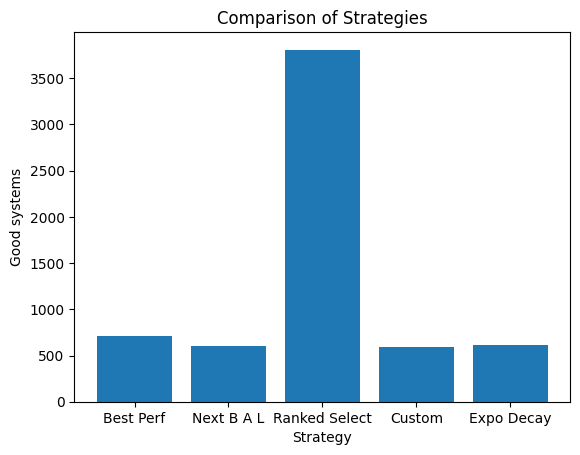

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Batch:
    def __init__(self, quality):
        self.quality = quality
        self.alpha = 1
        self.beta = 1

    def sample_distribution(self):
        return np.random.beta(self.alpha, self.beta)

    def get_element(self):
        good = np.random.rand() < self.quality
        self.alpha += int(good)
        self.beta += 1 - int(good)
        return good

class Factory:
    def __init__(self):
        self.batches = []
        self.systems = 0
        self.good = 0

    def set_batches(self, qualities):
        self.batches = [Batch(quality) for quality in qualities]

    def strategy_best_performed_so_far(self):
        best_quality = max(batch.alpha / (batch.alpha + batch.beta) for batch in self.batches)
        best_batch = next(batch for batch in self.batches if (batch.alpha / (batch.alpha + batch.beta)) == best_quality)
        result = best_batch.get_element()
        self.systems += 1
        self.good += result
        return result

    def strategy_next_batch_after_lemon(self):
        current_batch_index = 0
        results = []
        while self.systems < 1000:
            result = self.batches[current_batch_index].get_element()
            self.systems += 1
            self.good += result
            if not result:
                current_batch_index = (current_batch_index + 1) % len(self.batches)
            results.append(result)
        return results

    def strategy_ranked_selection(self):
        ranked_batches = sorted(self.batches, key=lambda batch: batch.alpha / (batch.alpha + batch.beta), reverse=True)
        results = []
        for i, batch in enumerate(ranked_batches):
            for _ in range(len(ranked_batches) - i):
                result = batch.get_element()
                self.systems += 1
                self.good += result
                results.append(result)
        return results

    def strategy_custom(self):
        probabilities = [batch.alpha / (batch.alpha + batch.beta) for batch in self.batches]
        probabilities = probabilities / np.sum(probabilities)
        batch = np.random.choice(self.batches, p=probabilities)
        result = batch.get_element()
        self.systems += 1
        self.good += result
        return result

    def strategy_exponential_decay(self, decay_rate=0.9):
        if self.systems == 0:
            return self.strategy_custom()  # Use custom strategy initially
        weights = np.array([decay_rate ** i for i in range(len(self.batches))])
        weighted_qualities = [batch.alpha / (batch.alpha + batch.beta) * weight for batch, weight in zip(self.batches, weights)]
        probabilities = weighted_qualities / np.sum(weighted_qualities)
        batch = np.random.choice(self.batches, p=probabilities)
        result = batch.get_element()
        self.systems += 1
        self.good += result
        return result

def compare_strategies():
    qualities = [0.5, 0.6, 0.7]
    strategies = {
        "Best Perf": lambda factory: factory.strategy_best_performed_so_far(),
        "Next B A L": lambda factory: factory.strategy_next_batch_after_lemon(),
        "Ranked Select": lambda factory: factory.strategy_ranked_selection(),
        "Custom": lambda factory: factory.strategy_custom(),
        "Expo Decay": lambda factory: factory.strategy_exponential_decay()
    }

    results = {strategy: [] for strategy in strategies}
    for strategy_name, strategy_fn in strategies.items():
        factory = Factory()
        factory.set_batches(qualities)
        for _ in range(1000):
            strategy_fn(factory)
        results[strategy_name] = factory.good

    for strategy_name, good_systems in results.items():
        print(f"Strategy: {strategy_name}, Good systems: {good_systems}")

    # Plot results
    plt.bar(results.keys(), results.values())
    plt.xlabel('Strategy')
    plt.ylabel('Good systems')
    plt.title('Comparison of Strategies')
    plt.show()

compare_strategies()

The exponential decay method was chosen as a custom strategy to address the potential
issue of changing batch quality over time. The idea was to give more weight to recent results,
assuming that the quality of batches might drift and recent performance would be more
indicative of current quality.
Why it was chosen:
- It adapts to changes in quality over time by emphasizing recent outcomes.
- It aims to balance the need to exploit known good batches while still considering the
possibility that batch quality might change over time.
In summary, the Ranked Selection strategy outperforms the others due to its structured
approach to balancing exploration and exploitation, leading to better long-term results. The
exponential decay method, while conceptually appealing for dynamic adaptation, may
require further tuning to effectively balance recent performance with overall batch quality.

Decay: 0.95, Good systems: 673
Decay: 0.98, Good systems: 707
Decay: 0.99, Good systems: 659


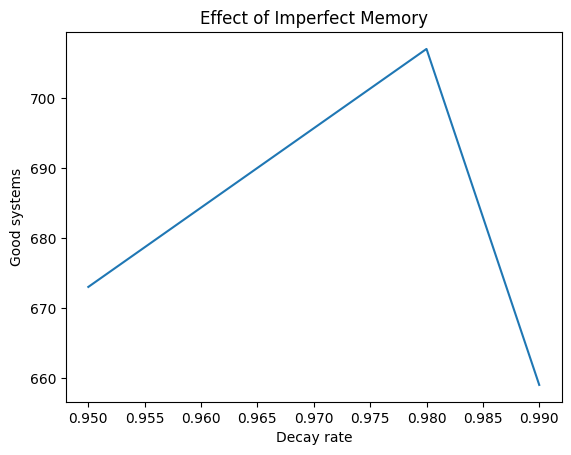

In [9]:
class BatchImperfectMemory(Batch):
    def __init__(self, quality, decay=0.99):
        super().__init__(quality)
        self.decay = decay

    def get_element(self):
        good = np.random.rand() < self.quality
        self.alpha = self.alpha * self.decay + int(good)
        self.beta = self.beta * self.decay + 1 - int(good)
        return good

class FactoryImperfectMemory(Factory):
    def __init__(self, decay=0.99):
        super().__init__()
        self.decay = decay

    def set_batches(self, qualities):
        self.batches = [BatchImperfectMemory(quality, self.decay) for quality in qualities]
        
    def get_element(self):
        samples = [batch.sample_distribution() for batch in self.batches]
        choice = np.argmax(samples)
        result = self.batches[choice].get_element()
        self.systems += 1
        self.good += result
        return result

# Example implementation with imperfect memory
def imperfect_memory_example():
    qualities = [0.5, 0.6, 0.7]
    decay_rates = [0.95, 0.98, 0.99]
    
    results = {decay: [] for decay in decay_rates}
    for decay in decay_rates:
        factory = FactoryImperfectMemory(decay=decay)
        factory.set_batches(qualities)
        for _ in range(1000):
            factory.get_element()
        results[decay] = factory.good

    for decay, good_systems in results.items():
        print(f"Decay: {decay}, Good systems: {good_systems}")

    # Plot results
    plt.plot(results.keys(), results.values())
    plt.xlabel('Decay rate')
    plt.ylabel('Good systems')
    plt.title('Effect of Imperfect Memory')
    plt.show()

imperfect_memory_example()

The highest number of good systems is achieved with the decay rate (0.98).
The plots of “Imperfect memory” can be different each time because of the randomness
inherent in the Bayesian strategy and the stochastic nature of drawing samples from the Beta
distribution. To address this, you can set a random seed to ensure reproducibility of results.

Example Scenario: Implementing and Checking Imperfect Memory
Let's create an example where batch qualities change over time to illustrate how the
imperfect memory strategy adapts to these changes.

Scenario Setup:
- We have three batches with initial qualities of 0.5, 0.6, and 0.7.
- After 500 iterations, the qualities of the batches change to 0.4, 0.5, and 0.8
respectively to simulate changes in manufacturing quality.
- We will implement the Bayesian strategy with imperfect memory and compare its
performance with a static environment.

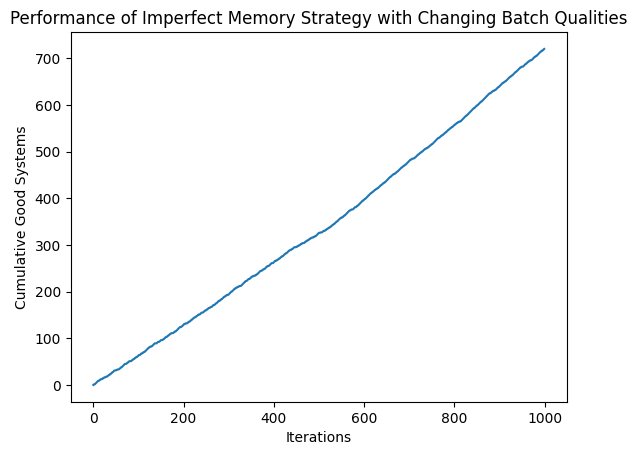

In [6]:
def simulate_quality_change():
    initial_qualities = [0.5, 0.6, 0.7]
    changed_qualities = [0.4, 0.5, 0.8]
    iterations_before_change = 500
    total_iterations = 1000
    decay_rate = 0.98

    factory = FactoryImperfectMemory(decay=decay_rate)
    factory.set_batches(initial_qualities)
    results = []

    for i in range(total_iterations):
        if i == iterations_before_change:
            factory.set_batches(changed_qualities)
        factory.get_element()
        results.append(factory.good)
    
    return results

# Run the simulation and plot the results
np.random.seed(42)  # Set random seed for reproducibility
results = simulate_quality_change()

# Plotting the cumulative good systems over time
plt.plot(results)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Good Systems')
plt.title('Performance of Imperfect Memory Strategy with Changing Batch Qualities')
plt.show()

The initial results suggest that the decay rate of 0.98 effectively balances memory retention
and adaptation, maintaining consistent performance even with changing batch qualities. The
revised simulation with more pronounced quality changes and additional decay rates will
help further validate and understand the strategy’s performance under different conditions.
This approach ensures a thorough evaluation of the strategy's effectiveness in dynamic
environments.